In [2]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import polars as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
import lightgbm as lgb  
import warnings
warnings.filterwarnings("ignore")

# Data

In [3]:
subpath = "/home/onyxia/work/AML/data/"
weights = pl.read_parquet(subpath + "weights.parquet")
target = pl.read_parquet(subpath + "target.parquet")
responders = pl.read_parquet(subpath + "responders.parquet")
features = pl.read_parquet(subpath + "features.parquet")

# Architecture

## MLP Buider

In [4]:
def make_mlp(widths, activation=nn.ReLU):
    """
    widths : [in_dim, h1, h2, ..., out_dim]
    """
    layers = []
    for in_f, out_f in zip(widths[:-1], widths[1:]):
        layers.append(nn.Linear(in_f, out_f))
        layers.append(activation())
    layers.pop()  # retire la dernière activation inutile
    return nn.Sequential(*layers)


## Auto-Encoder supervised & unsupervised

In [5]:
class Encoder(nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.net = make_mlp(widths)

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.net = make_mlp(widths)

    def forward(self, z):
        return self.net(z)


class TaskHead(nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.net = make_mlp(widths)

    def forward(self, z):
        return self.net(z)


## Build up

In [6]:
class FullModel(nn.Module):
    def __init__(self,
                 encoder_widths,   # ex : [input_dim, 256, 128, latent_dim]
                 decoder_widths,   # ex : [latent_dim, 128, 256, input_dim]
                 head_widths       # ex : [latent_dim, 64, output_dim]
                ):
        super().__init__()

        self.encoder = Encoder(encoder_widths)
        self.decoder = Decoder(decoder_widths)
        self.head = TaskHead(head_widths)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        y_hat = self.head(z)
        return z, x_hat, y_hat


## Utils

In [7]:
def r2_loss(y_true, y_pred):
    """
    R^2 est calculé via sklearn → numpy nécessaire.
    Loss = 1 - R^2 pour pouvoir backpropager.
    """
    y_t = y_true.detach().cpu().numpy()
    y_p = y_pred.detach().cpu().numpy()
    return 1 - r2_score(y_t, y_p)


In [ ]:
def train_model(
    model,
    X_train_t, y_train_t,
    X_test_t, y_test_t,
    n_epochs=60, batch_size=64,
    alpha=1.0, beta=1.0
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Move data to GPU
    X_train_t = X_train_t.to(device)
    y_train_t = y_train_t.to(device)
    X_test_t  = X_test_t.to(device)
    y_test_t  = y_test_t.to(device)

    # Convert y_test to numpy once for LGBM evaluation
    y_test_np = y_test_t.cpu().numpy()

    n = len(X_train_t)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scaler = GradScaler()

    r2_rec_test_list = []
    r2_sup_test_list = []
    r2_lgbm_test_list = [] # List to store LGBM R2
    loss_list = []

    for epoch in range(n_epochs):
        model.train() # Set model to training mode
        
        perm = torch.randperm(n, device=device)
        total_loss = 0.0

        # -------------------------
        #   TRAIN LOOP (PyTorch)
        # -------------------------
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            xb = X_train_t[idx]
            yb = y_train_t[idx]

            optimizer.zero_grad()

            with autocast():
                z, x_hat, y_hat = model(xb)

                loss_rec = F.mse_loss(x_hat, xb)
                loss_sup = F.mse_loss(y_hat, yb)
                loss = alpha * loss_rec + beta * loss_sup

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        # ---------------------------------
        #   R² SUR LE TEST SET + LGBM
        # ---------------------------------
        model.eval() # Set model to evaluation mode
        with torch.no_grad():
            # 1. Get embeddings for full train/test sets
            z_train, _, _ = model(X_train_t)
            z_test, x_hat_test, y_hat_test = model(X_test_t)
            
        # Convert embeddings and targets to NumPy for LGBM on CPU
        z_train_np = z_train.cpu().numpy()
        y_train_np = y_train_t.cpu().numpy() # Targets are already on CPU
        z_test_np = z_test.cpu().numpy()
        
        # --- 2. Train LGBM on the learned features (z_train) ---
        lgbm_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'n_estimators': 100,  # Quick training for evaluation
            'verbose': -1,
            'n_jobs': 1 # Use single core to avoid resource contention
        }
        
        lgbm_model = lgb.LGBMRegressor(**lgbm_params)
        lgbm_model.fit(z_train_np, y_train_np.flatten())

        # --- 3. Evaluate LGBM on the test features (z_test) ---
        y_lgbm_pred = lgbm_model.predict(z_test_np)
        
        # Calculate R2 for the LGBM prediction
        r2_lgbm_test = r2_score(y_test_np.flatten(), y_lgbm_pred)
        r2_lgbm_test_list.append(r2_lgbm_test)

        # --- 4. Calculate R2 for PyTorch TaskHead (as before) ---
        r2_rec_test = r2_score(X_test_t.cpu().numpy(),
                               x_hat_test.cpu().numpy())
        r2_sup_test = r2_score(y_test_t.cpu().numpy(),
                               y_hat_test.cpu().numpy())

        r2_rec_test_list.append(r2_rec_test)
        r2_sup_test_list.append(r2_sup_test)
        loss_list.append(total_loss)

        print(
            f"Epoch {epoch+1:02d} | loss={total_loss:.3f} "
            f"| R2_sup_NN={r2_sup_test:.4f} "
            f"| R2_sup_LGBM={r2_lgbm_test:.4f} "
            f"| R2_rec={r2_rec_test:.4f}"
        )

    return r2_rec_test_list, r2_sup_test_list, r2_lgbm_test_list, loss_list


In [ ]:
def plot_r2(r2_rec_list, r2_sup_list, r2_lgbm_list):
    """
    Plots the evolution of three R^2 metrics over epochs:
    1. Reconstruction (Autoencoder)
    2. Supervision (TaskHead)
    3. LightGBM (LGBM model trained on the latent code Z)
    """
    # Create 3 subplots stacked vertically, sharing the X-axis (Epoch)
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    # --- subplot 1 : reconstruction (Reconstruction R²) ---
    axes[0].plot(r2_rec_list, color="tab:blue")
    axes[0].set_ylabel("R² (Reconstruction)")
    axes[0].set_title("Evolution of R² Reconstruction (Encoder/Decoder)")
    axes[0].grid(True)

    # --- subplot 2 : supervision (NN TaskHead R²) ---
    axes[1].plot(r2_sup_list, color="tab:green")
    axes[1].set_ylabel("R² (NN Supervision)")
    axes[1].set_title("Evolution of R² Supervision (NN TaskHead)")
    axes[1].grid(True)

    # --- subplot 3 : LightGBM (LGBM R²) ---
    axes[2].plot(r2_lgbm_list, color="tab:orange")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("R² (LGBM on Z)")
    axes[2].set_title("Evolution of R² (LightGBM on Latent Code Z)")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()



# Train real data

In [ ]:
n = features.height
n_train = int(0.8 * n)

X_train = features.slice(0, n_train)
y_train = target.slice(0, n_train)

X_test = features.slice(n_train)
y_test = target.slice(n_train)

X_train_t = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_t = torch.tensor(y_train.to_numpy().reshape(-1,1), dtype=torch.float32)

X_test_t  = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_t  = torch.tensor(y_test.to_numpy().reshape(-1,1), dtype=torch.float32)

input_dim = X_train_t.shape[1]
latent_dim = 16
output_dim = 1
lr = 1e-2

model = FullModel(
    encoder_widths=[input_dim, 64, 32, latent_dim],
    decoder_widths=[latent_dim, 32, 64, input_dim],
    head_widths=[latent_dim, 32, output_dim]
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

r2_rec_test, r2_sup_test, losses = train_model(
    model,
    X_train_t, y_train_t,
    X_test_t, y_test_t,
    n_epochs=30,
    batch_size=512
)

Epoch 01 | loss=5877.232 | R2_sup_NN=-0.0021 | R2_LGBM=-0.0019 | R2_rec=-0.5715
Epoch 02 | loss=1607.385 | R2_sup_NN=-0.0011 | R2_LGBM=-0.0042 | R2_rec=-0.1095
Epoch 03 | loss=1488.486 | R2_sup_NN=-0.0029 | R2_LGBM=-0.0021 | R2_rec=-0.1316
Epoch 04 | loss=1432.515 | R2_sup_NN=-0.0046 | R2_LGBM=-0.0023 | R2_rec=-0.0234
Epoch 05 | loss=1398.637 | R2_sup_NN=0.0022 | R2_LGBM=-0.0067 | R2_rec=-0.1642
Epoch 06 | loss=1381.343 | R2_sup_NN=0.0003 | R2_LGBM=-0.0036 | R2_rec=-0.1065
Epoch 07 | loss=1360.495 | R2_sup_NN=0.0005 | R2_LGBM=-0.0035 | R2_rec=-0.2091
Epoch 08 | loss=1352.758 | R2_sup_NN=0.0010 | R2_LGBM=-0.0017 | R2_rec=-0.1471
Epoch 09 | loss=1348.103 | R2_sup_NN=-0.0014 | R2_LGBM=-0.0019 | R2_rec=-0.0349
Epoch 10 | loss=1341.911 | R2_sup_NN=-0.0012 | R2_LGBM=-0.0034 | R2_rec=0.0093
Epoch 11 | loss=1337.790 | R2_sup_NN=0.0007 | R2_LGBM=-0.0046 | R2_rec=0.1435
Epoch 12 | loss=1334.515 | R2_sup_NN=-0.0060 | R2_LGBM=-0.0020 | R2_rec=0.0504
Epoch 13 | loss=1332.544 | R2_sup_NN=-0.0049 | R

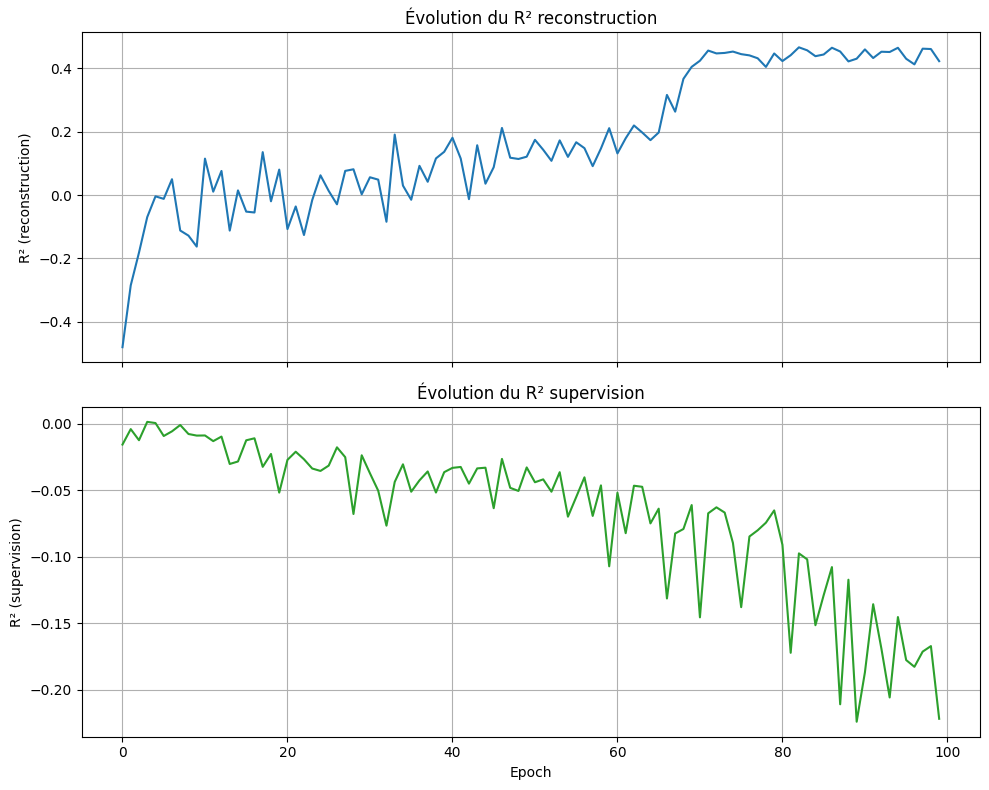

In [22]:
plot_r2(r2_rec_test, r2_sup_test)